In [69]:
import copy
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [2]:
def prepare_data(dataframe: pd.DataFrame):
    # Features to del
    features_to_del = ['Perimeter', 'MajorAxisLength', 
                       'MinorAxisLength', 'ConvexArea', 
                       'EquivDiameter', 'AspectRation', 
                       'Eccentricity', 'ShapeFactor3'
                       ]

    abod_detector = ABOD(contamination=0.05, n_neighbors=20, method='fast')
    outliers = abod_detector.fit_predict(dataframe.drop(["Class"], axis=1).to_numpy())
    df_with_detected_outliers = pd.concat([dataframe, pd.DataFrame(outliers, columns=["is_outlier"])], axis=1)
    df_cleaned = df_with_detected_outliers[df_with_detected_outliers["is_outlier"] == 0]
    df_cleaned = df_cleaned.drop(features_to_del, axis=1).drop(["is_outlier"], axis=1)
    scaler = MinMaxScaler()
    df_cleaned.loc[:, df_cleaned.columns != 'Class'] = scaler.fit_transform(df_cleaned.loc[:, df_cleaned.columns != 'Class'])
    return df_cleaned

In [3]:
df = pd.read_excel("../../data/Dry_Bean_Dataset.xlsx")
df_cleaned = prepare_data(df)
df_cleaned.head()

/Users/nikolajfonov/Programming/GitRepositories/comparison-of-bayesian-classifiers/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/var/folders/nm/_vhgd_nn6_q6j0v7y5gyx2p40000gn/T/ipykernel_91377/749219750.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04352619 0.0453764  0.04890216 ... 0.11853861 0.11858227 0.11864777]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cleaned.loc[:, df_cleaned.columns != 'Class'] = scaler.fit_transform(df_cleaned.loc[:, df_cleaned.columns != 'Class'])


,Area,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor4,Class
0,0.043526,0.671024,0.838660,0.922035,0.786733,0.573722,0.828019,0.971414,SEKER
1,0.045376,0.735504,0.725580,0.752553,0.903549,0.525508,0.966331,0.963094,SEKER
2,0.048902,0.716671,0.859193,0.897738,0.773514,0.561753,0.794945,0.981113,SEKER
3,0.052330,0.731365,0.483377,0.792905,0.829912,0.530710,0.850368,0.843167,SEKER
4,0.053050,0.700538,0.898182,0.986134,0.951583,0.487023,1.000000,0.983945,SEKER


In [4]:
df_cleaned.to_csv("../../data/Dry_Bean_Dataset_cleaned.csv")

In [5]:
x = df_cleaned.drop(["Class"], axis=1).to_numpy()
y = df_cleaned["Class"].to_numpy()

# Kernel comparison (4.1)

In [7]:
class Kernel:
    _kernels: list[KernelDensity]

    def __init__(self, kernel_type, bandwidth, dim):
        self._kernels = []
        for _ in range(dim):
            self._kernels.append(KernelDensity(kernel=kernel_type, bandwidth=bandwidth))
    
    def fit(self, x):
        for i in range(len(self._kernels)):
            self._kernels[i].fit(x[:,i].reshape((-1, 1)))
        
    def predict(self, x):
        result = []
        for i in range(len(self._kernels)):
            result.append(np.exp(self._kernels[i].score_samples(x[:,i].reshape((-1, 1)))))
        return np.array(result).T
    
    def predict_part(self, x, kde_num):
        return np.exp(self._kernels[kde_num].score_samples(x.reshape((-1, 1))))
    
    @property
    def dim(self):
        return len(self._kernels)

In [25]:
kernel_types = ["gaussian", "tophat", "epanechnikov", "exponential", "linear"]
bandwidths = [0.05, 0.1, 0.2, "silverman", 0.5, 1]

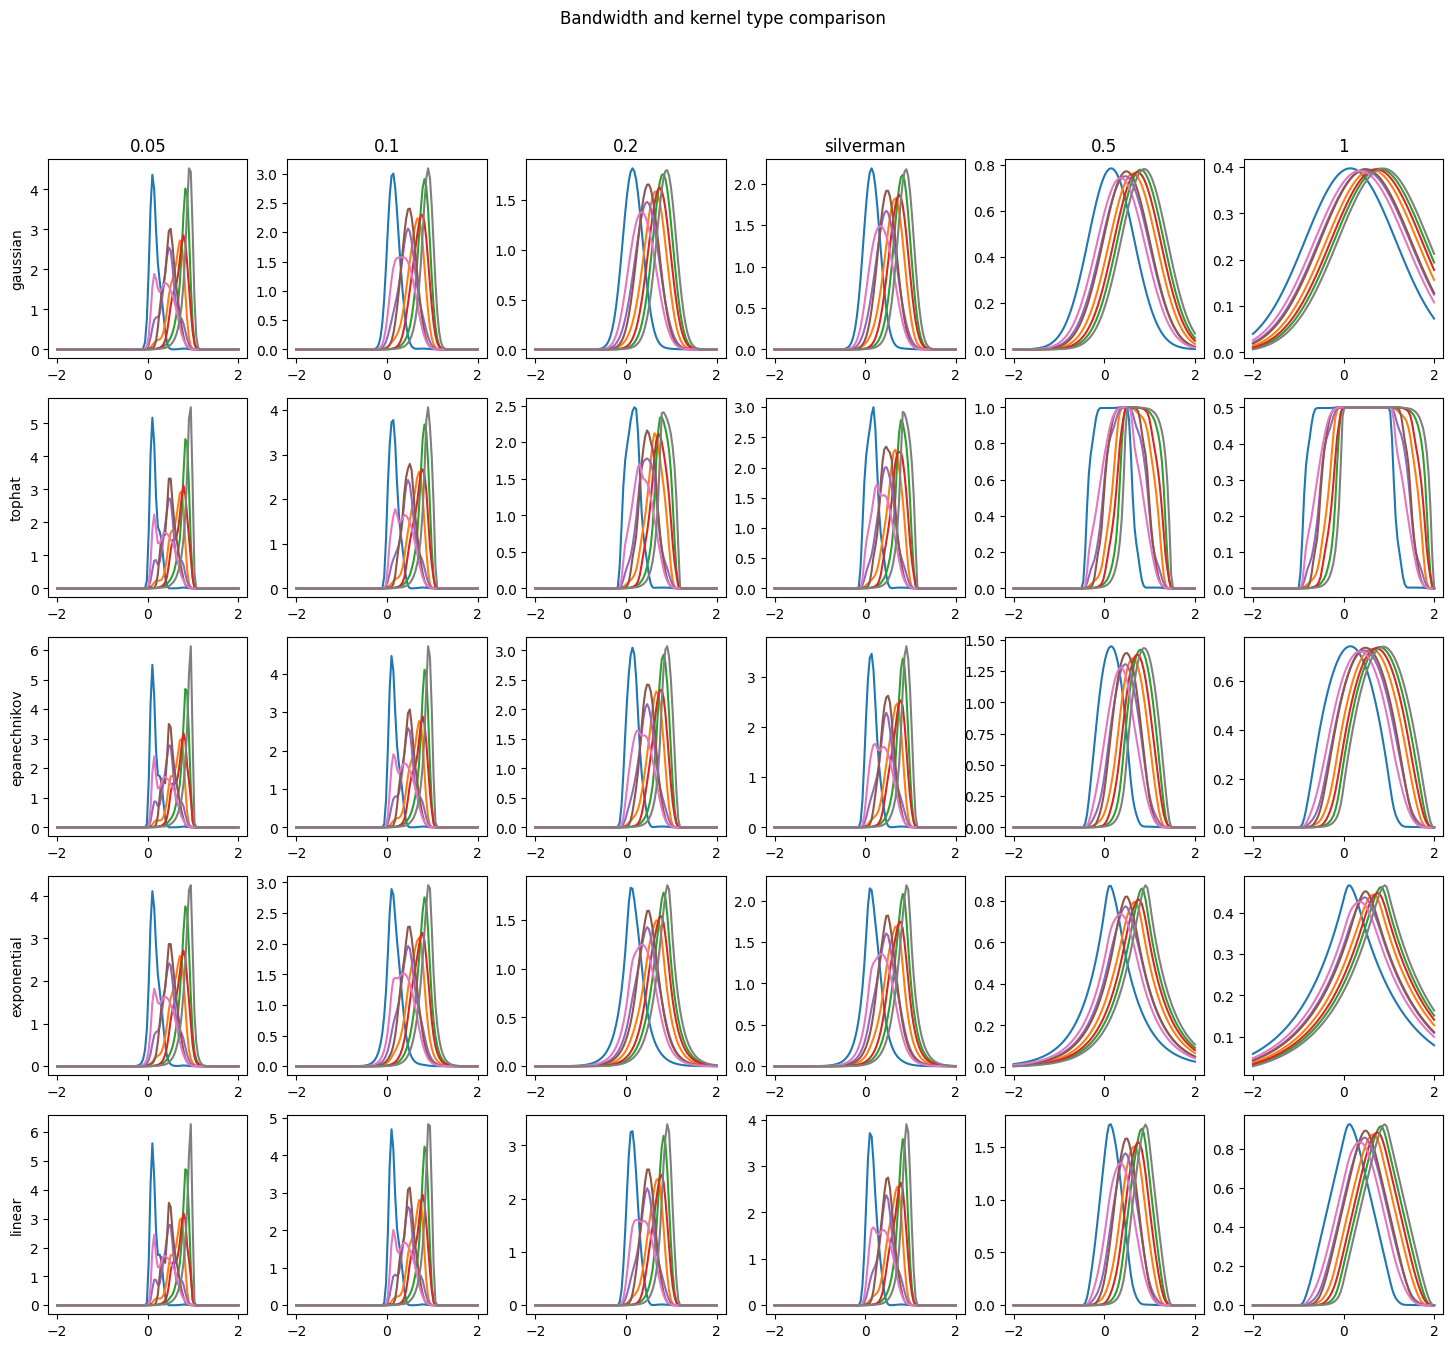

In [68]:
plt.figure(figsize=(18, 15))
#plt.tight_layout()

for i, j in itertools.product(range(len(kernel_types)), range(len(bandwidths))):
    plt.subplot(len(kernel_types), len(bandwidths), (i) * (len(kernel_types) + 1) + j + 1)
    kernel = Kernel(kernel_types[i], bandwidths[j], x.shape[1])
    kernel.fit(x)
    t = np.repeat(np.linspace(-2, 2, 100), kernel.dim).reshape(-1, kernel.dim)
    kde_pred = kernel.predict(t)
    plt.plot(t, kde_pred)
    if i == 0:
        plt.title(f"{bandwidths[j]}")
    if j == 0:
        plt.ylabel(f"{kernel_types[i]}")
plt.suptitle("Bandwidth and kernel type comparison")
plt.show()


# Nonparametric Bayes

Rule:
$$k^*=\arg\max_{k=\overline{1,K}}\tilde f_X(x|k)\tilde p_Y(k)$$
where:
- $\tilde p_Y(k) = \frac{n_y}{n}$;
- $ \tilde f(x)=\prod_{j=1}^M\tilde f_j(x_j)=\frac{1}{n^Mh_1*...*h_M}\prod_{j=1}^M\sum_{i=1}^nK(\frac{x_j-x_{ji}}{h_j})$;
- K – kernel.

In [70]:
# Nonparametric Bayes
class BayesianNonparametricalModel:
    _kernel_class: KernelDensity
    _kernel_params: dict
    _kernel_instances: dict[str: KernelDensity]
    _klass_probabilities: np.array
    _classes: np.array


    def __init__(self, kernel_params: dict) -> None:
        self._kernel_class = KernelDensity
        self._kernel_params = kernel_params
        self._kernel_instances = {}

    def fit(self, x, y) -> None:
        if x.shape[0] != y.shape[0]:
            raise Exception
        
        self._classes, counts = np.unique(y, return_counts=True)
        klass_probs = counts / np.sum(counts)
        self._klass_probabilities = {self._classes[i]: klass_probs[i] for i in range(len(klass_probs))}

        for klass in self._classes:
            klass_indexes = np.where(y == klass)
            x_k = x[klass_indexes]
            y_k = y[klass_indexes]
            
            kernel_k = self._kernel_class(**self._kernel_params)
            kernel_k.fit(x_k)
            self._kernel_instances[klass] = kernel_k
            
    def predict_proba(self, x) -> np.array:
        probs_arr = []
        for klass in self._classes:
            f_xk = np.exp(self._kernel_instances[klass].score_samples(x))
            f_k = self._klass_probabilities[klass]
            p_k = f_xk * f_k
            probs_arr.append(p_k)
        probs_arr = np.array(probs_arr).T # [[first element], ... , [last element]]
        norm_values = probs_arr.sum(axis=1)
        norm_values[norm_values == 0] = 1
        probs = probs_arr / norm_values[:, None]
        return probs

    def predict(self, x) -> np.array:
        probs = self.predict_proba(x)
        indexes_max_elements = probs.argmax(axis=1)
        return self._classes[indexes_max_elements]
    
    @property
    def classes(self):
        return copy.copy(self._classes)
    
    @property
    def klass_probabilities(self):
        return copy.copy(self._klass_probabilities)
    
    @property
    def kernel_params(self):
        return copy.copy(self._kernel_params)
    


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

kernel_params = {
    "kernel": "linear",
    "bandwidth": "silverman"
}
bnm = BayesianNonparametricalModel(kernel_params)
bnm.fit(X_train, y_train)
pred = bnm.predict(X_test)

accuracy_score(y_test, pred)

0.7575406032482599

In [73]:
def get_std_mean(kernels):
    res_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for i, (train_index, test_index) in enumerate(kf.split(x)):
            kernel_params = {
                "kernel": kernel,
                "bandwidth": "silverman"
            }
            bnm = BayesianNonparametricalModel(kernel_params)
            bnm.fit(x[train_index], y[train_index])
            pred = bnm.predict(x[test_index])

            
            res_dict[kernel].append(accuracy_score(y[test_index], pred))
    return res_dict

res = get_std_mean(kernels=kernel_types)

In [74]:
pd.DataFrame(res).describe().loc[["mean", "std"]]

,gaussian,tophat,epanechnikov,exponential,linear
mean,0.293426,0.462800,0.705491,0.274401,0.761717
std,0.010773,0.014716,0.014292,0.011902,0.009198


In [76]:
def get_std_mean(kernels, bandwith):
    res_mean_dict = {kernel: [] for kernel in kernels}
    res_std_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for bw in bandwith:
            bw_res = []
            for i, (train_index, test_index) in enumerate(kf.split(x)):
                kernel_params = {
                    "kernel": kernel,
                    "bandwidth": bw
                }
                bnm = BayesianNonparametricalModel(kernel_params)
                bnm.fit(x[train_index], y[train_index])
                pred = bnm.predict(x[test_index])

                
                bw_res.append(accuracy_score(y[test_index], pred))
            res_mean_dict[kernel].append(np.mean(bw_res))
            res_std_dict[kernel].append(np.std(bw_res))
    return res_mean_dict, res_std_dict

res = get_std_mean(kernels=kernel_types, bandwith=bandwidths)

In [82]:
print("Mean")
pd.DataFrame(res[0], index=bandwidths)

Mean


,gaussian,tophat,epanechnikov,exponential,linear
0.05,0.920572,0.685305,0.702011,0.907966,0.708043
0.1,0.905568,0.885924,0.891725,0.885770,0.890874
0.2,0.856999,0.907038,0.911910,0.807502,0.912220
silverman,0.293426,0.462954,0.705259,0.274401,0.761176
0.5,0.336814,0.494277,0.781980,0.385615,0.827224
1,0.273086,0.274478,0.307657,0.273086,0.349188


In [83]:
print("STD")
pd.DataFrame(res[1], index=bandwidths)

STD


,gaussian,tophat,epanechnikov,exponential,linear
0.05,0.004470,0.021692,0.011101,0.004536,0.012539
0.1,0.006904,0.007396,0.011106,0.007703,0.007597
0.2,0.008093,0.007027,0.007438,0.011146,0.009159
silverman,0.014345,0.011586,0.008376,0.009356,0.012339
0.5,0.009827,0.011904,0.006964,0.013329,0.014249
1,0.007478,0.014512,0.010693,0.013473,0.015873


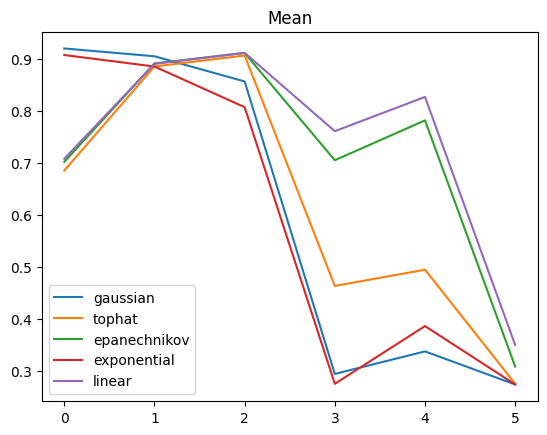

In [91]:
for kernel in kernel_types:
    plt.plot(res[0][kernel], label=kernel)
    plt.legend()
    plt.title("Mean")

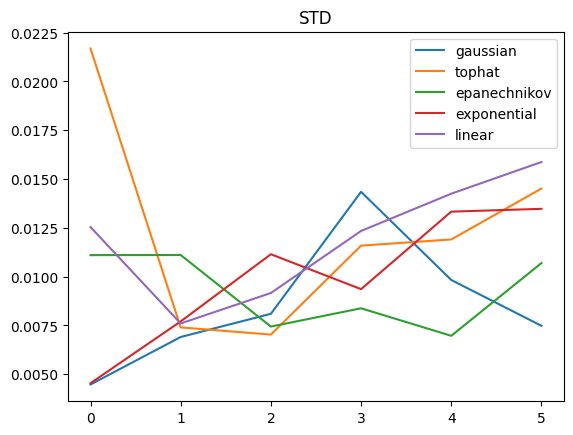

In [92]:
for kernel in kernel_types:
    plt.plot(res[1][kernel], label=kernel)
    plt.legend()
    plt.title("STD")